In [1]:
import numpy as np
import matplotlib.pyplot as plt

import SMBHBpy
from SMBHBpy import constants as c
from SMBHBpy import merger_system as ms

### Define the SMBH binary
The code works in geometrized units with $c=G=1$. All units are converted to parsecs (pc) before use, using the conversion factors included in constants.py.

In [2]:
m1 =  8.0*1e7 * c.solar_mass_to_pc             # The mass of the first SMBH
m2 =  8.0*1e7 * c.solar_mass_to_pc             # The mass of the second SMBH

D_luminosity = 1e8                             # The (measured) distance to the system from earth [pc]

sigma = 200 *10**3*c.m_to_pc/(c.s_to_pc)       # Velocity dispersion of the host galaxy-bulge
b_max = 10  *10**3                             # Maximum impact parameter for calculating the Coulomb logarithm

# k: Indicates whether the halos are static (k = 0) or non-static, i.e. rotating (k=1), 
# k = 0 can be selected independently of the eccentricity e, k = 1 only if circular orbits (e=0) are involved.
k = 0.

### Define the dark matter spike properties

In [3]:
# Define a cold dark matter spike around each SMBH
# https://arxiv.org/pdf/1408.3534.pdf

r_sp_1 = 0.2*m1/sigma**2
r_sp_2 = 0.2*m2/sigma**2

alpha_1 = 7./3.
alpha_2 = 7./3.

rho_sp_1 = (3-alpha_1)*0.2**(3-alpha_1)*m1/(2*np.pi*r_sp_1**3)
rho_sp_2 = (3-alpha_1)*0.2**(3-alpha_1)*m2/(2*np.pi*r_sp_2**3)

spike_1 = SMBHBpy.halo.Spike(rho_sp_1, r_sp_1, alpha_1)
spike_2 = SMBHBpy.halo.Spike(rho_sp_2, r_sp_2, alpha_2)

# For GW-only, i.e. without spikes around the SMBHs, for comparison
spike_1_GW = SMBHBpy.halo.Spike(0., r_sp_1, alpha_1)
spike_2_GW = SMBHBpy.halo.Spike(0., r_sp_2, alpha_2)

### Define initial conditions for a circular inspiral

In [4]:
# Create the SystemProp object describing the SMBH binary with DM spikes
sp = ms.SystemProp(m1, m2, spike_1, spike_2, sigma, b_max, k, D=D_luminosity)   

# Create the SystemProp object describing the SMBH binary with DM spikes + relativistic corrections to dynamical Friction
sp_rel = ms.SystemProp(m1, m2, spike_1, spike_2, sigma, b_max, k, D=D_luminosity, relcorr = True)

# For GW-only, i.e. without spikes around the SMBHs, for comparison
sp_GW = ms.SystemProp(m1, m2, spike_1_GW, spike_2_GW, sigma, b_max, k, D=D_luminosity)


R0 = 50 * (sp.r_isco_1()+sp.r_isco_2())      # Initial separation
R_fin = sp.r_isco_1()+sp.r_isco_2()          # The final condition for the evolution

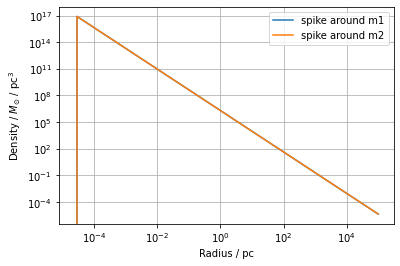

In [5]:
# Plot density distributions
r_grid1 = np.geomspace(sp.r_isco_1(), 1e5, 100) 
r_grid2 = np.geomspace(sp.r_isco_2(), 1e5, 100)
plt.loglog(r_grid1, spike_1.density(r_grid1)/c.solar_mass_to_pc, label='spike around m1')
plt.loglog(r_grid2, spike_2.density(r_grid2)/c.solar_mass_to_pc, label='spike around m2')
plt.grid(); plt.xlabel("Radius / pc"); plt.ylabel("Density / $M_{\odot}$ / pc$^3$"); plt.legend(); plt.show()

### Solve the differential equations

In [6]:
# Solve the differential equations for DM spikes
ev = SMBHBpy.inspiral.Classic.Evolve(sp, R0, a_fin = R_fin)

# Solve the differential equations for DM spikes + relativistic corrections to dynamical friction
ev_rel = SMBHBpy.inspiral.Classic.Evolve(sp_rel, R0, a_fin = R_fin)

# For GW-only, i.e. without spikes around the SMBHs, for comparison
ev_GW = SMBHBpy.inspiral.Classic.Evolve(sp_GW, R0, a_fin = R_fin)

Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 0.0786s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 0.0663s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 0.1583s


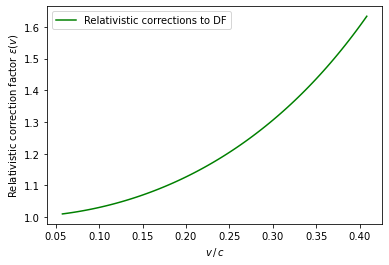

In [7]:
# Relativistic corrections to dynamical friction during the hole inspiral
v = np.sqrt(sp.m_total()/ev.R)
epsilon_v = 1./(1-v**2) * (1+v**2)**2
plt.plot(v,epsilon_v, label = "Relativistic corrections to DF", color = "green")
plt.xlabel("$v\,/\,c$"); plt.ylabel("Relativistic correction factor $\u03B5(v)$"); plt.legend()
plt.show()

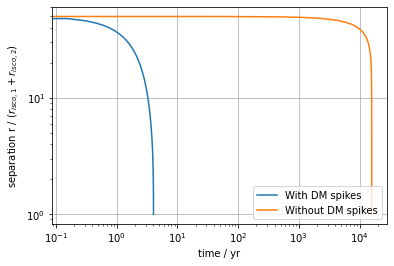

In [8]:
# Plot the results for the temporal evolution of the distance r between the SMBHs
plt.loglog(ev.t/c.year_to_pc, ev.R/(sp.r_isco_1()+sp.r_isco_2()), label = "With DM spikes")
#plt.loglog(ev_rel.t/c.year_to_pc, ev_rel.R/(sp.r_isco_1()+sp.r_isco_2()), label = "With DM spikes + rel. corr. to DF")
plt.loglog(ev_GW.t/c.year_to_pc, ev_GW.R/(sp.r_isco_1()+sp.r_isco_2()), label = "Without DM spikes")
plt.grid(); plt.legend(loc = "lower right"); plt.xlabel("time / yr"); plt.ylabel("separation r / ($r_{isco,1}+r_{isco,2}$)"); plt.show()

In [9]:
# Total evolution time in days with DM spikes:
print("With DM spikes:", ev.t[-1]/c.year_to_pc*365.25, "days")

# Total evolution time in days with DM spikes + relativistic corrections to DF:
print("With DM spikes + rel. corr. to DF:", ev_rel.t[-1]/c.year_to_pc*365.25,"days","(",ev_rel.t[-1]/ev.t[-1],"%)")

# Total evolution time in years (GW-only):
print("Without DM spikes:", ev_GW.t[-1]/c.year_to_pc, "years")

With DM spikes: 1481.692167063026 days
With DM spikes + rel. corr. to DF: 1435.0185193083046 days ( 0.9684997675008049 %)
Without DM spikes: 15861.616261197398 years


### Calculate the gravitational wave signal

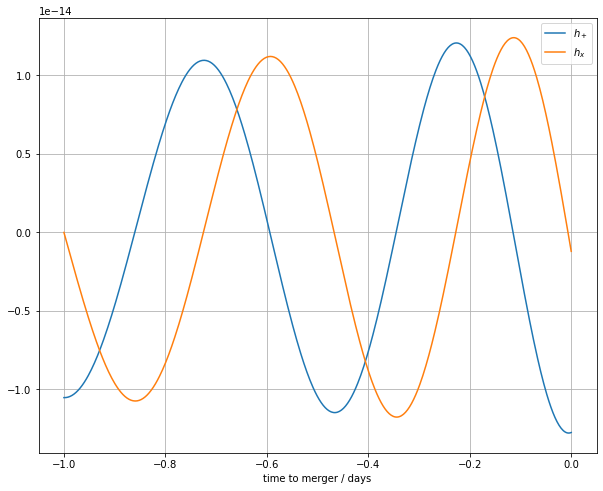

In [10]:
# The gravitational wave signal right before coalescence
tom = ev.t[-1]                                             # time of "merger"
t_grid = np.linspace(tom - 24*3600.*c.s_to_pc, tom, 500)   # Look at the last 1 day of inspiral
h_plus, h_cross = SMBHBpy.waveform.h(sp, ev, t_grid)

plt.figure(figsize=(10,8))
plt.plot((t_grid - tom)/(c.s_to_pc*24*3600), h_plus, label="$h_+$")
plt.plot((t_grid - tom)/(c.s_to_pc*24*3600), h_cross, label="$h_x$")
plt.grid(); plt.legend(); plt.xlabel("time to merger / days"); plt.show()

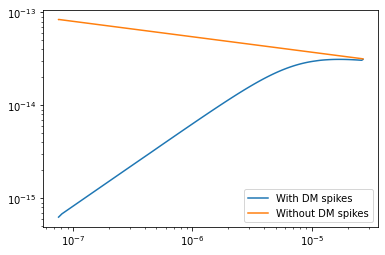

In [11]:
# The characteristic strain of the signal with DM spikes
f_gw, h_2_plus, h_2_cross, psi = SMBHBpy.waveform.h_2(sp, ev)
plt.loglog(f_gw/c.hz_to_invpc, 2.* f_gw*h_2_plus, label="With DM spikes")

# For GW-only, i.e. without spikes around the SMBHs, for comparison
f_gw_GW, h_2_plus_GW, h_2_cross_GW, psi_GW = SMBHBpy.waveform.h_2(sp_GW, ev_GW)
plt.loglog(f_gw_GW/c.hz_to_invpc, 2.* f_gw_GW*h_2_plus_GW, label="Without DM spikes")

# LISA:
#Lisa = SMBHBpy.detector.Lisa()
#f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
#plt.loglog(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA')

plt.legend(loc = "lower right")
plt.show()

### Do the same for an eccentric inspiral

In [12]:
a0 = 50. * (sp.r_isco_1()+sp.r_isco_2())          # initial semi-major axis
e0 = 0.75                                         # initial eccentricity

a_fin = (sp.r_isco_1()+sp.r_isco_2())             # final condition for a

# Solve the differential equations
ev_ecc = SMBHBpy.inspiral.Classic.Evolve(sp, a0, e_0=e0,  a_fin = R_fin)

Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.75  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 36.8310s


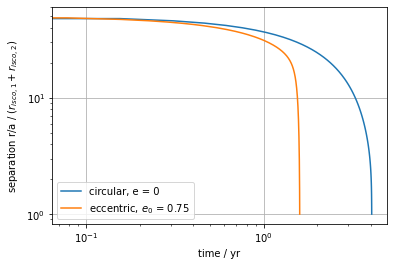

In [13]:
# Plot the results and compare to the circular case
plt.loglog(ev.t/c.year_to_pc,  ev.R/(sp.r_isco_1()+sp.r_isco_2()), label='circular, e = 0')
plt.loglog(ev_ecc.t/c.year_to_pc,  ev_ecc.a/(sp.r_isco_1()+sp.r_isco_2()), label='eccentric, $e_0$ = '+str(e0))
plt.grid(); plt.legend(); plt.xlabel("time / yr"); plt.ylabel("separation r/a / $(r_{isco,1}+r_{isco,2})$"); plt.show()

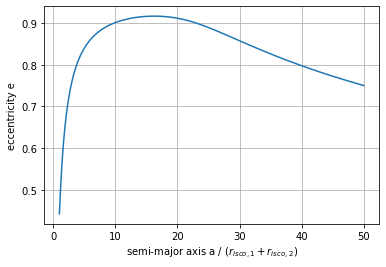

In [14]:
# Plot eccentricity vs. semimajor axis
plt.plot(ev_ecc.a/(sp.r_isco_1()+sp.r_isco_2()), ev_ecc.e)
plt.grid(); plt.xlabel("semi-major axis a / $(r_{isco,1}+r_{isco,2})$"); plt.ylabel("eccentricity e"); plt.show()

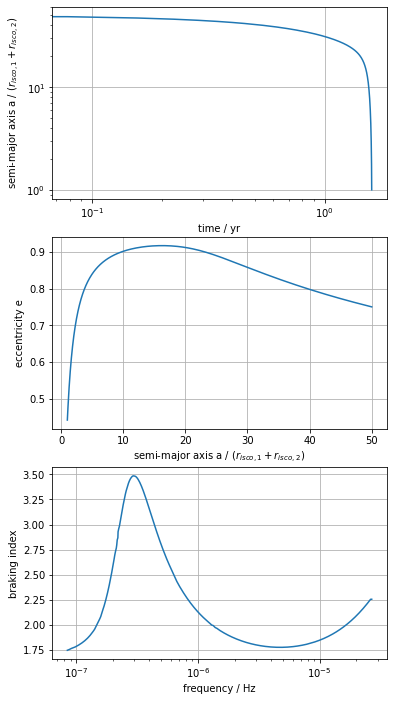

In [15]:
# Alternatively use the plot_utils
fig, axes = plt.subplots(3,1, figsize=(6, 12))
SMBHBpy.plot_utils.plotEvolution(sp, ev_ecc, ax_a=axes[0], ax_ae=axes[1], ax_n=axes[2])
axes[0].grid(); axes[0].set_xlabel("time / yr"); axes[0].set_ylabel("semi-major axis a / $(r_{isco,1}+r_{isco,2})$")
axes[1].grid(); axes[1].set_xlabel("semi-major axis a / $(r_{isco,1}+r_{isco,2})$"); axes[1].set_ylabel("eccentricity e");
axes[2].grid(); axes[2].set_xscale('log'); axes[2].set_xlabel("frequency / Hz"); axes[2].set_ylabel("braking index"); plt.show()

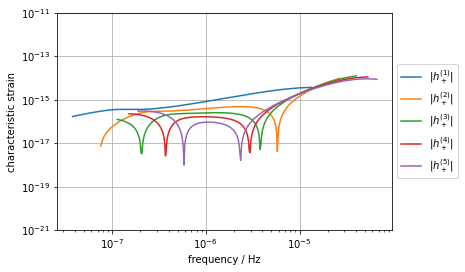

In [16]:
# Plot the first five harmonics
n_comp = 5

wfs = [SMBHBpy.waveform.h_n(n, sp, ev_ecc, acc=1e-13) for n in range(1, n_comp+1)]

for i in range(len(wfs)):
    plt.loglog(wfs[i][0]/c.hz_to_invpc, 2.*wfs[i][0]*np.abs(wfs[i][1]), label=r"$|h^{(" + str(i+1) + ")}_+|$")
    
plt.grid(); plt.xlabel("frequency / Hz"); plt.ylabel("characteristic strain"); plt.ylim(bottom=1e-21, top=1e-11)

# LISA:    
#Lisa = SMBHBpy.detector.Lisa()
#f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
#plt.loglog(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); plt.show()